In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import csv
from os import path

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [22]:
db_path = path.join("..", "db.sqlite3")
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

cursor.execute('''
    SELECT
        o.id AS order_id,
        o.datetime AS order_datetime,
        i.id AS orderitem_id,
        i.quantity AS orderitem_quantity,
        p.id AS product_id,
        p.price AS product_price,
        p.name AS product_name
    FROM
        restaurant_order o
        JOIN restaurant_orderitem i ON o.id = i.order_id
        JOIN restaurant_product p ON i.product_id = p.id
''')

with open('output.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow([description[0] for description in cursor.description])
    writer.writerows(cursor.fetchall())

conn.close()

df = pd.read_csv(path.join("output.csv"), index_col=[2])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74818 entries, 1 to 74818
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            74818 non-null  int64  
 1   order_datetime      74818 non-null  object 
 2   orderitem_quantity  74818 non-null  int64  
 3   product_id          74818 non-null  int64  
 4   product_price       74818 non-null  float64
 5   product_name        74818 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.0+ MB


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

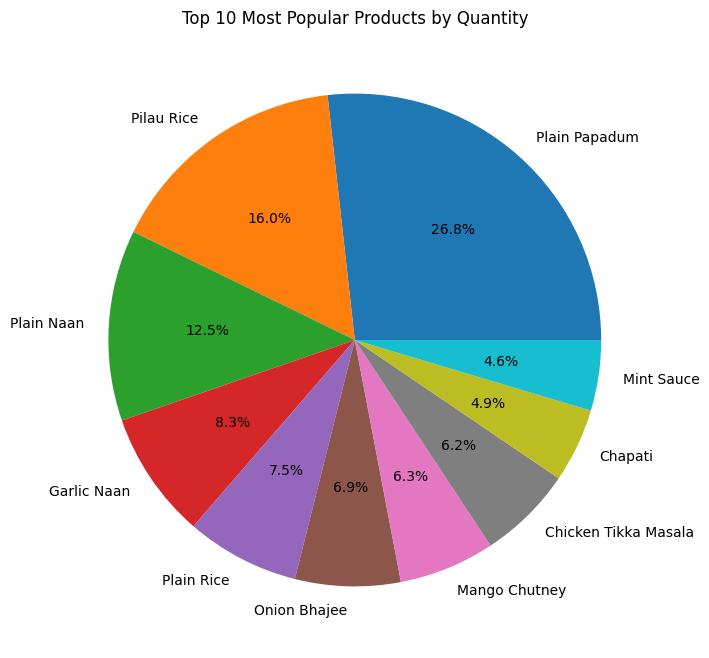

In [23]:
top_products = df.groupby(['product_id', 'product_name'])['orderitem_quantity'].sum().nlargest(10).reset_index()
top_products['popularity_pct'] = top_products['orderitem_quantity'] / top_products['orderitem_quantity'].sum() * 100
plt.figure(figsize=(8, 8))
plt.pie(top_products['popularity_pct'], labels=top_products['product_name'], autopct='%1.1f%%')
plt.title('Top 10 Most Popular Products by Quantity')
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

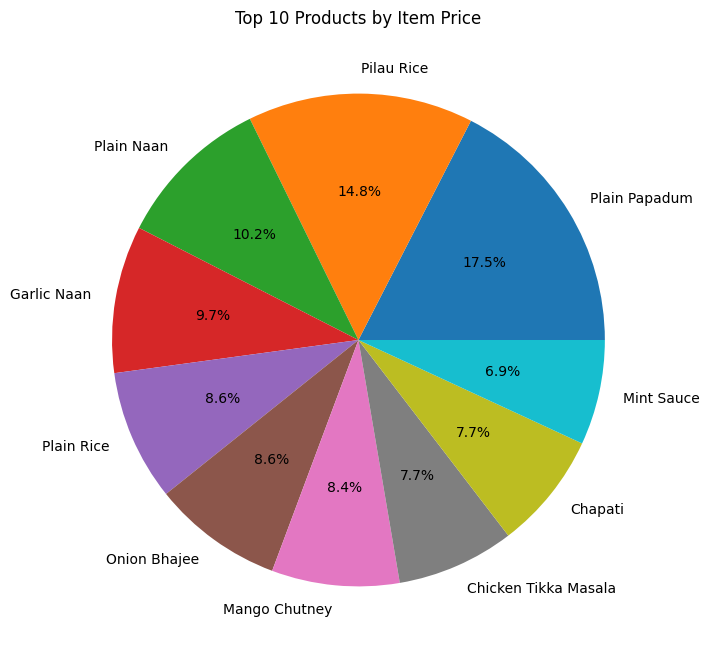

In [24]:
df["item_price"] = df["orderitem_quantity"] * df["product_price"]
top10_by_price = df.groupby("product_name").sum()["item_price"].nlargest(10)

plt.figure(figsize=(8, 8))
plt.pie(top10_by_price, labels=top_products['product_name'], autopct='%1.1f%%')
plt.title("Top 10 Products by Item Price")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

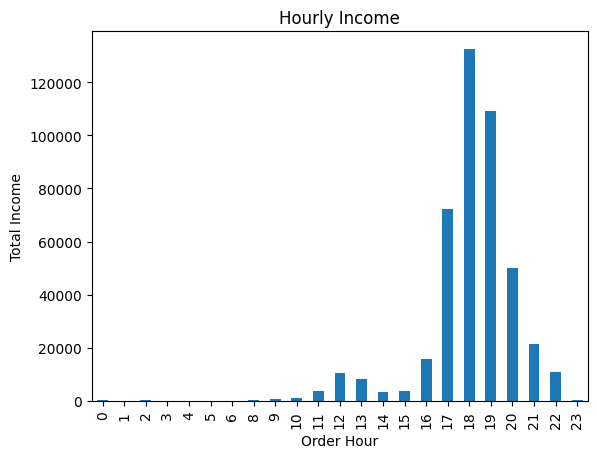

In [25]:
df["order_datetime"] = pd.to_datetime(df["order_datetime"])
df["order_hour"] = df["order_datetime"].dt.hour
hourly_income = df.groupby("order_hour")["item_price"].sum()
hourly_income_bar = hourly_income.plot(kind="bar")
plt.xlabel("Order Hour")
plt.ylabel("Total Income")
plt.title("Hourly Income")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

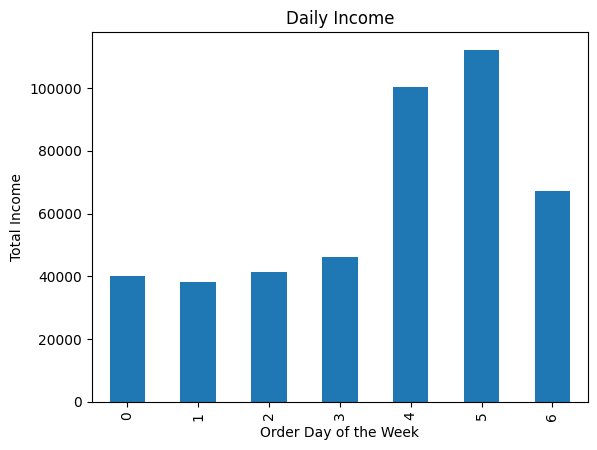

In [26]:
df["order_day_of_week"] = df["order_datetime"].dt.dayofweek
daily_income = df.groupby("order_day_of_week")["item_price"].sum()
daily_income_bar = daily_income.plot(kind="bar")
plt.xlabel("Order Day of the Week")
plt.ylabel("Total Income")
plt.title("Daily Income")
plt.show()